# Revision v2

# 1. Setup and preprocessing

In [1]:
library(broom)
suppressPackageStartupMessages(library(cmprsk))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))
library(knitr)
suppressPackageStartupMessages(library(kableExtra))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(recipes))
library(rsample)
suppressPackageStartupMessages(library(survival))
suppressPackageStartupMessages(library(tidyverse))

latest_date <- as_date('2020-08-01')

## 1.1. Helper functions

In [2]:
mutate_named <- function(data, column, value) {
    if (is.factor(data[[column]])) {
        lev <- levels(data[[column]])
        new_values <- factor(rep(value, nrow(data)), levels = lev)
        mutate(data, {{column}} := new_values)
    } else {
        mutate(data, {{column}} := as.numeric(value))
    }
}

austin_method <- function(data, formula, strata, fit_method, predict_method) {
    # Return a list with the predicted values for each stratum
    # https://doi.org/10.1016/j.jclinepi.2009.03.012
    # Fit the method passed
    fit <- fit_method(formula, data)
    # Names for the strata will be '{name}{stratum}'
    names <- paste(names(strata), strata, sep = '')
    levels <- strata %>% names %>% map(~levels(data[[.x]]))
    imap(
        strata,
        ~data %>% 
            mutate_named(.y, .x) %>%
            predict_method(fit, .)
    ) %>%
    set_names(names)
}

bootstrap_austin_method <- function(data, formula, strata, fit_method, predict_method, n_bootstraps) {
    set.seed(0)
    data %>%
        bootstraps(n_bootstraps, apparent = T) %>%
        rowwise() %>%
        mutate(
            boot = splits %>%
                as.data.frame %>%
                austin_method(., formula, strata, fit_method, predict_method) %>%
                list
        ) %>%
        ungroup %>%
        select(-splits) %>%
        unnest_longer(boot) %>% 
        rename(bootstrap_iteration = id)
}

fit_fine_gray <- function(formula, data) {
    # Evaluate the survival object in the data environment
    surv_meta <- eval(formula[[2]], envir = data)
    time_to_event <- surv_meta[, 1]
    # Evaluate the outcome separately (to get it as a nice factor vector)
    outcome <- eval(formula[[2]][[3]], envir = data)
    
    # Pull the covariates from the original data using all terms on the RHS.
    # Remove the first column ('(Intercept)') because this is inappropriate
    # for Fine-Gray regression.
    covariates <- model.matrix(formula, data)[, -1]
    
    # Codes are used for the outcome of interest and censoring (2 and 1, resp.)
    failure_code = attributes(surv_meta)$inputAttributes$event$levels[[2]]
    censor_code = attributes(surv_meta)$inputAttributes$event$levels[[1]]

    output <- cmprsk::crr(ftime = time_to_event, fstatus = outcome, cov1 = covariates, 
        failcode = failure_code, cencode = censor_code)
    
    output[['call']] <- match.call()
    output[['formula']] <- formula
    output[['colnames']] <- colnames(covariates)
    output
}

predict_fine_gray <- function(fit, newdata, full_matrix = F) {
    covariates <- model.matrix(fit$formula, newdata)[, -1]
    preds <- predict(fit, cov1 = covariates)
    preds <- matrix(preds, nrow(preds))
    
    if (full_matrix) {
        preds
    } else {
        preds[nrow(preds), -1]
    }
}

# 2. Load data

In [2]:
basic_df <- read_tsv('abo_basic.txt', trim_ws = T, na = c('', 'NA', 'NULL'), col_types = cols()) %>%
    filter(age >= 18)

reg_df <- basic_df %>%
    mutate(
        abo = abo %>% fct_relevel(c('O', 'A', 'AB', 'B')),
        race = race %>% fct_relevel(c('white', 'missing', 'black', 'other', 'asian')),
        rh = as.double(rh == 'neg')
    ) %>%
    recipe() %>%
    step_dummy(race) %>%
    prep %>% 
    juice

tests_df <- read_tsv('abo_tests.txt', trim_ws = T, na = c('', 'NA', 'NULL'), col_types = cols())

# 3. Analysis

In [3]:
prevalence_df <- tests_df %>%
    group_by(pat_mrn_id) %>%
    mutate(
        hours_since_first_test = as.numeric(as.duration(
            test_result_datetime - min(test_result_datetime))) / (3600),
        positive = as.numeric(event_desc == 'Test: positive')
    ) %>%
    summarize(
        cov_pos = max(positive),
        initial_cov_pos = max(as.logical(positive) & (hours_since_first_test <= 96)),
        .groups = 'drop'
    )

## 3.1. Table 1

In [5]:
format_number <- function(number) {
    if (first(number) %% 1 == 0) {
        paste(as.integer(number))
    } else if (abs(first(number)) < 1) {
        formatC(100 * number, digits = 1, format = 'f', flag = '#')
    } else if (abs(first(number)) > 100) {
        formatC(number, digits = 1, format = 'f', flag = '#')
    } else {
        round(number, 0)
    }
}

format_percent <- function(column, N) {
    str_glue('{format_number(column)} ({format_number(column / N)})')
}

In [6]:
table_1_df <- prevalence_df %>% 
    inner_join(basic_df, by = 'pat_mrn_id') %>%
    unite('blood_type', c('abo', 'rh'), sep = '~') %>%
    separate_rows('blood_type', sep = '~') %>%
    mutate(blood_type = factor(blood_type, levels = c('A', 'AB', 'B', 'O', 'neg', 'pos'))) %>%
    recipe %>%
    step_dummy(race, one_hot = T) %>%
    prep %>%
    juice %>%
    group_by(blood_type) %>%
    summarize(
        N = n(),
        median_age = median(age),
        age_25 = quantile(age, 0.25),
        age_75 = quantile(age, 0.75),
        across(c(male, hispanic, starts_with('race'), initial_cov_pos, 
                 cov_pos, intubated, died), ~as.integer(sum(., na.rm = T))),
        .groups = 'drop'
    ) %>%
    # Add fraction by blood group type for `N`
    mutate(blood_group_type = if_else(blood_type %in% c('pos', 'neg'), 'rh', 'abo')) %>%
    group_by(blood_group_type) %>%
    mutate(frac_N = N / sum(N)) %>%
    ungroup %>%
    mutate(
        across(where(is.double), format_number),
        age = str_glue('{median_age} ({age_25} to {age_75})'),
        across(c(where(is.integer), -N), ~format_percent(., N)),
        N = str_glue('{N} ({frac_N})'),
        across(-blood_type, as.character),
    ) %>%
    select(blood_type, N, age, male, hispanic, starts_with('race'), initial_cov_pos, cov_pos, 
           intubated, died) %>%
    pivot_longer(N:died) %>%
    pivot_wider(names_from = blood_type, values_from = value)

In [7]:
table_1 <- table_1_df %>%
    mutate(
        name = name %>% str_replace_all(c('race_' = '')) %>% str_to_sentence %>% 
            str_replace_all(c('Cov_pos' = 'COV+', 'Intubated' = 'COV+/Intubated', 
                              'Died' = 'COV+/Died', 'Initial_cov_pos' = 'Initially COV+',
                              'Age' = 'Age (IQR)', '(?<![\\)N])$' = ' (%)'))
    ) %>%
    rename(' ' = name, 'Rh-neg' = neg, 'Rh-pos' = pos) %>%
    kable('html') %>%
    pack_rows('Race', 5, 9, label_row_css = 'padding-left: 1em; text-align:left;') %>%
    pack_rows('Outcomes', 10, 13, label_row_css = 'text-align:left;') %>%
    kable_styling(c("condensed", "hover", "responsive"), full_width = F, font_size = 13) 

table_1 %>%
    as.character %>%
    cat(file = '../../git/abo_covid/content/table1.html')

## 3.2. Prepare data

In [4]:
prevalence_reg_df <- prevalence_df %>% inner_join(reg_df, by = 'pat_mrn_id')

In [5]:
# Data formatted specifically for test of intubation
intubation_reg_df <- reg_df %>%
    # Only people who tested positive
    drop_na(intubated) %>%
    # Require people enter the cohort no later than July 15
    filter(cohort_entry_time <= '2020-07-31') %>%
    # Add death as a competing risk for intubation
    mutate(       
        censor_time = pmin(intubation_censor_time, death_censor_time, latest_date),
        outcome = case_when(
                pmin(intubation_censor_time, death_censor_time) > latest_date ~ 'censor', 
                intubation_censor_time < death_censor_time ~ 'intubation',
                as.logical(died) ~ 'death',
                died == 0 & intubated == 0 ~ 'recovery'
            ) %>%
            fct_relevel('censor', 'intubation', 'death', 'recovery'),
        survival_time = as.numeric(as.duration(censor_time - cohort_entry_time)) / (3600 * 24)
    ) %>%
    # Remove people censored before cohort entry and with Do Not Intubate (DNI) orders
    filter(cohort_entry_time <= censor_time, is.na(dnr_date) | dnr_date > censor_time) %>%
    select(abo, rh, age, male, starts_with('race'), hispanic, outcome, survival_time)

intubation_process_data <- intubation_reg_df %>%
    recipe() %>%
    step_dummy(abo) %>%
    prep()

In [6]:
# Data formatted specifically for test of intubation
death_reg_df <- reg_df %>%
    # Only people who tested positive
    drop_na(died) %>%
    # Require people enter the cohort no later than July 15
    filter(cohort_entry_time <= '2020-07-31') %>%
    # Add death as a competing risk for intubation
    mutate(        
        censor_time = pmin(death_censor_time, latest_date),
        outcome = case_when(
                death_censor_time > latest_date ~ 'censor',
                as.logical(died) ~ 'death',
                TRUE ~ 'recovery'
            ) %>%
            fct_relevel('censor', 'death', 'recovery'),
        survival_time = as.numeric(as.duration(censor_time - cohort_entry_time)) / (3600 * 24)
    ) %>%
    # Remove people censored before cohort entry
    filter(cohort_entry_time <= censor_time) %>%
    select(abo, rh, age, male, starts_with('race'), hispanic, outcome, survival_time)

death_process_data <- death_reg_df %>%
    recipe() %>%
    step_dummy(abo) %>%
    prep()

In [9]:
intubation_reg_df %>% filter(outcome == 'censor') %>% nrow

[1] 21

In [10]:
death_reg_df %>% filter(outcome == 'censor') %>% nrow

[1] 22

## 3.3. Analysis 

1. Prevalence in first tests (≤96 hours of first recorded test)
2. Intubation survival analysis
3. Death survival analysis

In [11]:
blood_type_to_strata <- list(
    abo = list(abo = 'A', abo = 'AB', abo = 'B', abo = 'O'),
    rh = list(rh = 1, rh = 0)
)
base_formulae <- list(
    'unadjusted' = '{y} ~ {x}',
    'adjusted' = '{y} ~ {x} + race_asian + race_black + race_missing + race_other + hispanic'
)
x <- list('abo', 'rh')
y <- list(
    'prevalence' = 'initial_cov_pos', 
    'intubation' = 'Surv(survival_time, outcome)', 
    'death' = 'Surv(survival_time, outcome)'
)
data <- list(
    'prevalence' = prevalence_reg_df, 
    'intubation' = intubation_reg_df, 
    'death' = death_reg_df
)
fit_methods <- list(
    'prevalence' = lm, 
    'intubation' = fit_fine_gray, 
    'death' = fit_fine_gray
)
predict_methods <- list(
    'prevalence' = function(fit, data) predict(fit, data) %>% mean, 
    'intubation' = function(fit, data) predict_fine_gray(fit, data) %>% mean, 
    'death' = function(fit, data) predict_fine_gray(fit, data) %>% mean
)

In [12]:
n_bootstraps <- 1000

set.seed(0)
bootstrap_df <- list(model = names(base_formulae), x = x, outcome = names(y)) %>%
    cross_df() %>%
    rowwise() %>%
    mutate(
        formula = base_formulae[[model]],
        y = y[[outcome]],
        formula = formula %>% str_glue %>% as.formula %>% list,
        strata = list(blood_type_to_strata[[x]]),
        estimates = bootstrap_austin_method(
            data[[outcome]], formula, strata, fit_methods[[outcome]], 
            predict_methods[[outcome]], n_bootstraps) %>%
            list
    ) %>%
    ungroup %>%
    select(-formula, -strata) %>%
    unnest(estimates) %>%
    select(outcome, model, blood_group = x, stratum = boot_id, bootstrap_iteration, boot)

bootstrap_df %>% write_tsv('bootstraps.tsv')

## 3.4. Format results

In [13]:
bootstrap_df <- read_tsv('bootstraps.tsv')

Parsed with column specification:
cols(
  outcome = col_character(),
  model = col_character(),
  blood_group = col_character(),
  stratum = col_character(),
  bootstrap_iteration = col_character(),
  boot = col_double()
)



In [68]:
summary_df <- bootstrap_df %>%
    nest(data = -blood_group) %>%
    rowwise() %>%
    mutate(
        data = data %>%
            pivot_wider(id_cols = c('outcome', 'bootstrap_iteration', 'model'), 
                        names_from = 'stratum', values_from = 'boot') %>%
            pivot_longer(cols = any_of(c('aboO', 'rh0')), names_to = 'reference_group', 
                         values_to = 'reference') %>%
            mutate(across(c(-outcome, -bootstrap_iteration, -model, -reference_group),
                          ~paste(., . - reference, 1 / (. - reference), . / reference, sep = '~'))) %>%
            pivot_wider(names_from = reference_group, values_from = reference) %>%
            pivot_longer(-c('outcome', 'bootstrap_iteration', 'model'), names_to = 'stratum', 
                         values_to = 'boot') %>%
            list
    ) %>%
    ungroup %>%
    unnest(data) %>%
    pivot_wider(id_cols = c('outcome', 'blood_group', 'stratum', 'model'), 
                names_from = bootstrap_iteration, values_from = boot) %>%
    pivot_longer(starts_with('Bootstrap'), names_to = 'bootstrap_iteration', values_to = 'boot') %>%
    separate(boot, c('boot_risk', 'boot_risk_difference', 'boot_NNT', 'boot_RR'), sep = '~', convert = T) %>%
    # Compute empirical confidence intervals across bootstrap iterations
    group_by(outcome, blood_group, stratum, model, Apparent) %>%
    summarize(
        risk.conf.low = quantile(boot_risk, 0.025),
        risk.conf.high = quantile(boot_risk, 0.975),
        diff.conf.low = quantile(boot_risk_difference, 0.025),
        diff.conf.high = quantile(boot_risk_difference, 0.975),
        NNT.conf.low = quantile(boot_NNT, 0.025),
        NNT.conf.high = quantile(boot_NNT, 0.975),
        RR.conf.low = quantile(boot_RR, 0.025),
        RR.conf.high = quantile(boot_RR, 0.975),
        .groups = 'drop'
    ) %>%
    separate(Apparent, c('risk', 'risk_difference', 'NNT', 'relative_risk'), sep = '~', convert = T) %>%
    mutate(
        stratum = stratum %>% str_replace_all(c('0' = 'Rh-pos', '1' = 'Rh-neg', 'abo' = '', 'rh' = '')),
        blood_group = blood_group %>% str_replace_all(c('abo' = 'ABO', 'rh' = 'Rh(D)')),
        outcome = outcome %>% str_to_sentence,
        across(c(outcome, stratum), fct_rev),
    )

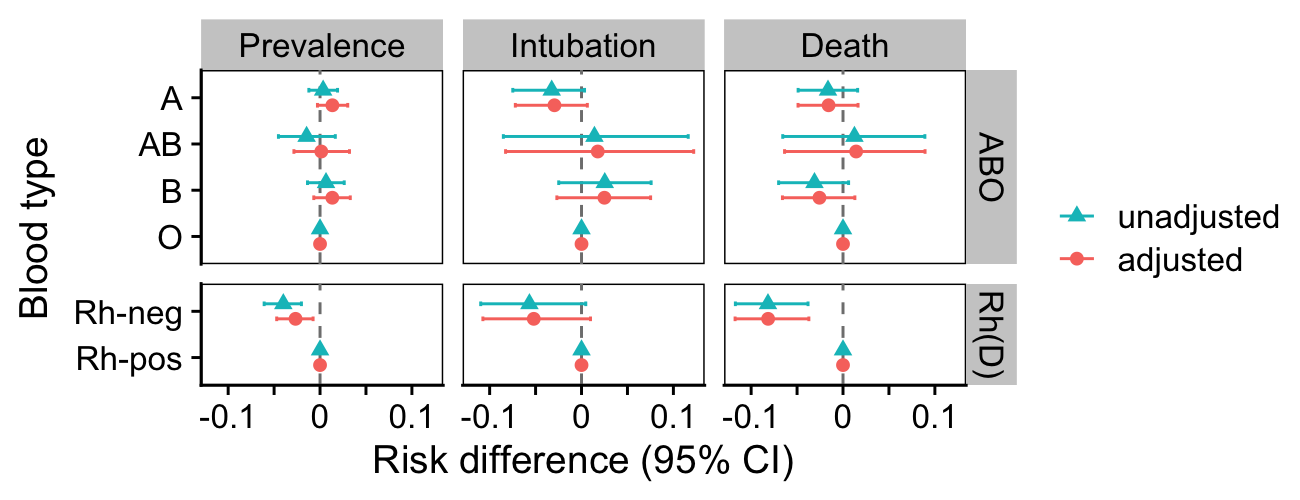

In [69]:
forest_plot <- summary_df %>%
    ggplot(aes(x = risk_difference, xmin = diff.conf.low, xmax = diff.conf.high,
               y = stratum, color = model, shape = model)) +
    geom_vline(xintercept = 0, color = 'grey50', linetype = 'dashed') +
    geom_errorbarh(position = position_dodge(width = 0.65), height = 0.2) +
    geom_point(position = position_dodge(width = 0.65), size = 2) +
    facet_grid(rows = vars(blood_group), cols = vars(outcome), scales = 'free_y', space = 'free_y') +
    xlab('Risk difference (95% CI)') +
    ylab('Blood type') +
    theme_cowplot() +
    theme(
        legend.title = element_blank(),
        panel.background = element_rect(color = 'black')
    ) +
    guides(color = guide_legend(reverse = T), shape = guide_legend(reverse = T)) +
    scale_x_continuous(n.breaks = 6, breaks = c(-0.1, -0.05, 0, 0.05, 0.1),
                       labels = c('-0.1', '', '0', '', '0.1'))

options(repr.plot.width = 6.5, repr.plot.height = 2.5, repr.plot.res = 200)

ggsave(forest_plot, filename = '../../git/abo_covid/content/images/forest.png', width = 6.5, height = 2.5, dpi = 400)

forest_plot

In [70]:
formatted_summary <- summary_df %>%
    mutate(       
        across(c(starts_with('risk'), starts_with('diff')),
               ~formatC(100 * ., digits = 1, format = 'f', flag = '#')),
        across(c(relative_risk, starts_with('NNT'), starts_with('RR')),
               ~formatC(., digits = 2, format = 'f', flag = '#')),
        risk = str_glue('{risk} ({risk.conf.low} to {risk.conf.high})'),
        `risk difference` = str_glue('{risk_difference} ({diff.conf.low} to {diff.conf.high})'),
        NNT = str_glue('{NNT} ({NNT.conf.low} to {NNT.conf.high})'),
        `relative risk` = str_glue('{relative_risk} ({RR.conf.low} to {RR.conf.high})'),
        across(everything(), as.character),
        across(`risk difference`:`relative risk`, ~if_else(stratum %in% c('O', 'Rh-pos'), '—', .)),
    ) 

table_2 <- formatted_summary %>%
    select(outcome, blood_group, stratum, model, risk, `risk difference`, `relative risk`) %>%
    nest(metrics = c(risk:`relative risk`)) %>%
    pivot_wider(names_from = model, values_from = metrics) %>%
    relocate(adjusted, .after = unadjusted) %>%
    arrange(desc(outcome)) %>%
    select(-blood_group) %>%
    unnest(c(adjusted, unadjusted), names_repair = 'minimal') %>%
    set_names('Outcome', 'Blood type', 'Risk', 'Risk difference', 'Risk ratio', 
              'Risk', 'Risk difference', 'Risk ratio') %>%
    kable('html', align = 'l') %>%
    add_header_above(c(" " = 2, "Unadjusted" = 3, "Race/ethnicity adjusted" = 3)) %>%
    collapse_rows(columns = 1:2, valign = "middle") %>%
    kable_styling(c("condensed"), full_width = F, font_size = 13) 
    
table_2 %>%
    as.character %>%
    cat(file = '../../git/abo_covid/content/table2.html')

In [71]:
table_2 %>% as.character %>% IRdisplay::display_html()

Unadjusted 
 Race/ethnicity adjusted 
 
 
 Outcome 
 Blood type 
 Risk 
 Risk difference 
 Risk ratio 
 Risk 
 Risk difference 
 Risk ratio 
 
 
 
 
 Prevalence 
 A 
 17.5 (16.3 to 18.8) 
 0.3 (-1.2 to 1.9) 
 1.02 (0.93 to 1.12) 
 18.0 (16.8 to 19.2) 
 1.3 (-0.3 to 3.0) 
 1.08 (0.98 to 1.19) 
 
 
 
 AB 
 15.7 (12.8 to 18.7) 
 -1.5 (-4.5 to 1.7) 
 0.91 (0.74 to 1.10) 
 16.8 (13.9 to 19.8) 
 0.1 (-2.8 to 3.2) 
 1.01 (0.83 to 1.20) 
 
 
 
 B 
 17.9 (16.1 to 19.5) 
 0.7 (-1.4 to 2.6) 
 1.04 (0.92 to 1.16) 
 18.0 (16.3 to 19.7) 
 1.3 (-0.7 to 3.3) 
 1.08 (0.96 to 1.20) 
 
 
 
 O 
 17.2 (16.2 to 18.1) 
 — 
 — 
 16.7 (15.7 to 17.6) 
 — 
 — 
 
 
 
 Rh-pos 
 17.7 (17.0 to 18.4) 
 — 
 — 
 17.6 (16.9 to 18.3) 
 — 
 — 
 
 
 
 Rh-neg 
 13.7 (11.8 to 15.5) 
 -4.0 (-6.1 to -2.0) 
 0.77 (0.66 to 0.88) 
 14.9 (13.0 to 16.8) 
 -2.7 (-4.7 to -0.8) 
 0.85 (0.73 to 0.96) 
 
 
 Intubation 
 A 
 17.2 (14.2 to 20.1) 
 -3.2 (-7.5 to 0.3) 
 0.84 (0.66 to 1.02) 
 17.3 (14.3 to 20.4) 
 -2.9 (-7.2 to 0.6) 
 0.85 (0.68 to 1.03) 
 
 
 
 AB 
 21.8 (12.3 to 31.7) 
 1.4 (-8.5 to 11.6) 
 1.07 (0.59 to 1.57) 
 22.1 (12.8 to 32.1) 
 1.8 (-8.3 to 12.2) 
 1.09 (0.60 to 1.59) 
 
 
 
 B 
 22.9 (18.6 to 27.6) 
 2.5 (-2.5 to 7.6) 
 1.12 (0.89 to 1.40) 
 22.8 (18.6 to 27.5) 
 2.5 (-2.7 to 7.5) 
 1.12 (0.88 to 1.40) 
 
 
 
 O 
 20.4 (17.8 to 23.4) 
 — 
 — 
 20.3 (17.7 to 23.3) 
 — 
 — 
 
 
 
 Rh-pos 
 20.3 (18.4 to 22.1) 
 — 
 — 
 20.2 (18.4 to 22.1) 
 — 
 — 
 
 
 
 Rh-neg 
 14.6 (9.7 to 20.7) 
 -5.7 (-11.0 to 0.5) 
 0.72 (0.47 to 1.02) 
 15.0 (9.9 to 21.0) 
 -5.2 (-10.7 to 1.0) 
 0.74 (0.48 to 1.05) 
 
 
 Death 
 A 
 13.3 (11.0 to 15.7) 
 -1.6 (-4.9 to 1.6) 
 0.89 (0.71 to 1.11) 
 13.2 (10.9 to 15.6) 
 -1.6 (-4.9 to 1.6) 
 0.89 (0.71 to 1.12) 
 
 
 
 AB 
 16.1 (8.5 to 23.8) 
 1.2 (-6.6 to 8.9) 
 1.08 (0.58 to 1.62) 
 16.2 (8.7 to 23.5) 
 1.4 (-6.4 to 8.9) 
 1.10 (0.59 to 1.64) 
 
 
 
 B 
 11.8 (8.6 to 15.0) 
 -3.1 (-7.0 to 0.6) 
 0.79 (0.56 to 1.05) 
 12.2 (9.0 to 15.5) 
 -2.6 (-6.6 to 1.3) 
 0.83 (0.58 to 1.09) 
 
 
 
 O 
 14.9 (12.9 to 17.1) 
 — 
 — 
 14.8 (12.7 to 16.9) 
 — 
 — 
 
 
 
 Rh-pos 
 14.5 (13.0 to 16.0) 
 — 
 — 
 14.5 (13.0 to 16.0) 
 — 
 — 
 
 
 
 Rh-neg 
 6.3 (3.0 to 10.1) 
 -8.2 (-11.7 to -3.8) 
 0.44 (0.21 to 0.72) 
 6.4 (3.0 to 10.3) 
 -8.2 (-11.7 to -3.7) 
 0.44 (0.21 to 0.74)